In [1]:
# Suggested imports. You may add your own here.

%matplotlib inline

import collections
from collections import Counter
import random
import matplotlib.pyplot as plt
import nltk
import numpy as np
import torch

# Other Imports
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import math

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Text compression assignment

It is said that you can measure the intelligence of an AI from the amount it can compress a text without information loss.
One way to think about this is that, the more a text is predictable, the more words we can leave out of it as we can guess the missing words.
On the other hand, the more intelligent an AI is, the more it will find texts to be predictable and so the more words it can leave out and guess.
This has led to a competition called the [Hutter Prize](http://prize.hutter1.net/) where the objective is to compress a given text as much as possible.
The record for compressing a 1GB text file extracted from a Wikipedia snapshot is about 115MB.
The main hurdle here is that the program used to decompress the file must be treated as part of the compressed file, meaning that the program itself must also be small.

In this assignment, you're going to be doing something similar using a smaller text file and using neural language models to guess missing words.

## 1) Data processing (10%)

You have a train/dev/test split corpus of text from Wikipedia consisting of single sentences.
Each sentence is on a separate line and each sentence has been tokenised for you such that tokens are space separated.
This means that you only need to split by space to get the tokens.
The text has all been lowercased as well.
The objective here is to be able to compress the text losslessly, meaning that it can be decompressed back to the original string:

$$\text{decompress}(\text{compress}(t)) = t$$

Do not do any further pre-processing on the text (such as stemming) as it may result in unrecoverable information loss.
The test set is what we will be compressing and will not be processed at all as it will be treated as a single big string by the compression/decompression algorithms.

Do the following tasks:

1.1) Load the train set and dev set text files into a list of sentences where each sentence is tokenised (by splitting by space).
Do not load the test set.

In [2]:
# Function to load and tokenize sentences from a text file
def load_and_tokenize(file_path):
    # Open the file with read permissions and UTF-8 encoding
    with open(file_path, 'r', encoding='utf-8') as f:
        # Read all lines from the file into a list
        sentences = f.readlines()
    # Return a list of tokenized sentences
    # Each sentence is stripped of leading/trailing whitespaces and then split by spaces
    return [sentence.strip().split(' ') for sentence in sentences]

# Define the paths to the train and dev text files
train_file_path = 'train.txt'
dev_file_path = 'dev.txt'

# Load and tokenize the sentences from the train set
train_sentences = load_and_tokenize(train_file_path)
# Load and tokenize the sentences from the dev set
dev_sentences = load_and_tokenize(dev_file_path)

# Take the first 3 tokenized sentences from the train set as sample data
sample_train = train_sentences[:3]
# Take the first 3 tokenized sentences from the dev set as sample data
sample_dev = dev_sentences[:3]

# Print the sample data from the train set to verify the output
print("Sample Train Sentences:\n\n", sample_train)
# Print the sample data from the dev set to verify the output
print("\nSample Dev Sentences:\n\n", sample_dev)

Sample Train Sentences:

 [['dr.', 'tonie', 'mcdonald', 'is', 'a', 'life', 'long', 'levittown', 'resident', 'who', 'taught', 'and', 'rose', 'through', 'the', 'ranks', 'of', 'the', 'district', 'she', 'now', 'leads', '.'], ['he', 'received', 'his', 'ba', 'in', 'chemistry', ',', 'magna', 'cum', 'laude', ',', 'from', 'amherst', 'college', 'in', '1', '9', '8', '1', '.'], ['the', 'growth', 'of', 'twin', 'cities', 'international', 'airport', 'during', 'the', 'last', 'half', 'of', 'the', 'twentieth', 'century', 'along', 'with', 'additions', 'of', 'land', 'to', 'the', 'fort', 'snelling', 'compound', 'meant', 'further', 'reductions', '.']]

Sample Dev Sentences:

 [['jones', 'viewed', 'the', 'resolution', 'as', 'the', 'framework', ',', 'and', 'not', 'the', 'final', 'solution', ',', 'for', 'enabling', 'librarians', 'to', 'confront', 'issues', 'that', 'hampered', '``', 'human', 'freedom', "''", '.'], ['he', 'lives', 'in', 'ottawa', ',', 'where', 'he', 'composes', 'full-time', '.'], ['many', 'natur

1.2) Extract a vocabulary consisting of the tokens that occur at least 3 times in the train set and output the size of your vocabulary.
Also output the most frequent vocabulary token in the train set, which should be 'the'.
Include the edge token, unknown token, and pad token in the vocabulary.

In [3]:
# Count the frequency of each token in the train set
# This uses a nested list comprehension to flatten the list of sentences into a list of tokens
# The Counter class then counts the occurrences of each token
token_counter = Counter(token for sentence in train_sentences for token in sentence)

# Create a vocabulary by filtering out tokens that appear less than 3 times in the train set
# This is done using a set comprehension
vocab = {token for token, count in token_counter.items() if count >= 3}

# Define a set of special tokens: Padding, Unknown, and Edge tokens
special_tokens = {'<PAD>', '<UNK>', '<EDGE>'}

# Add the special tokens to the vocabulary
vocab.update(special_tokens)

# Testing: Check if special tokens are in the vocabulary
assert '<PAD>' in vocab, "'<PAD>' not found in vocab"
assert '<UNK>' in vocab, "'<UNK>' not found in vocab"
assert '<EDGE>' in vocab, "'<EDGE>' not found in vocab"

# Calculate the size of the vocabulary by taking the length of the vocab set
vocab_size = len(vocab)

# Find the most frequent token in the train set
# The most_common(1) method returns a list with a single tuple, hence [0][0] to get the token
most_frequent_token = token_counter.most_common(1)[0][0]

# Output the vocabulary size and the most frequent token for verification
print(f"Vocabulary Size: {vocab_size}\n")
print(f"Most Frequent Token: {most_frequent_token}")

Vocabulary Size: 7874

Most Frequent Token: the


1.3) Process the loaded token sequences for the train set and dev set using the vocabulary created above in a way that is suitable for a language model, making use of edge tokens, unknown tokens, and pad tokens.
Do not do this for the test set as well.

In [4]:
# Function to process and pad sentences for training a language model
def process_sentences_dynamic(sentences, vocab):
    # Find the length of the longest sentence
    max_length = max(len(sentence) for sentence in sentences) + 2  # +2 for the two EDGE tokens
    
    # Initialize an empty list to hold the processed sentences
    processed = []  
    for sentence in sentences:
        # Add an initial edge token and replace tokens not in vocab with '<UNK>'
        new_sentence = ['<EDGE>'] + [token if token in vocab else '<UNK>' for token in sentence]
        
        # Pad the sentence and then add an edge token
        while len(new_sentence) < max_length - 1:  # Leave space for one edge token
            new_sentence.append('<PAD>')
        new_sentence.append('<EDGE>')  # Add the final edge token

        # Add the processed and padded sentence to the list
        processed.append(new_sentence)
            
    return processed

# Process the train and dev sentences
processed_train_sentences = process_sentences_dynamic(train_sentences, vocab)
processed_dev_sentences = process_sentences_dynamic(dev_sentences, vocab)

# Show some sample processed data for verification
sample_processed_train = processed_train_sentences[:3]
sample_processed_dev = processed_dev_sentences[:3]

# Print the first 3 processed and padded sentences from both the train and dev sets
print("Sample Processed Train Sentences:\n\n", sample_processed_train)
print("\nSample Processed Dev Sentences:\n\n", sample_processed_dev)

Sample Processed Train Sentences:

 [['<EDGE>', 'dr.', '<UNK>', 'mcdonald', 'is', 'a', 'life', 'long', '<UNK>', 'resident', 'who', 'taught', 'and', 'rose', 'through', 'the', 'ranks', 'of', 'the', 'district', 'she', 'now', 'leads', '.', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<EDGE>'], ['<EDGE>', 'he', 'received', 'his', 'ba', 'in', 'chemistry', ',', '<UNK>', '<UNK>', '<UNK>', ',', 'from', '<UNK>', 'college', 'in', '1', '9', '8', '1', '.', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<EDGE>'], ['<EDGE>', 'the', 'growth', 'of', 'twin', 'cities', 'international', 'ai

1.4) Finally, load the test set text file as single string and keep it in a variable.

In [5]:
# Function to load the test set into a single string
def load_test_set(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()
        # Remove trailing whitespace, including newlines
        return content.rstrip()  

# Specify the path to the test text file
test_file_path = 'test.txt'

# Load the test set using the function
test_set_string = load_test_set(test_file_path)

# Output the total length of the test set string
print(f"\nTotal length of Test Set: {len(test_set_string)} characters\n")

# Output the first 100 characters of the test set for verification
print("First 100 characters of Test Set:\n\n", test_set_string[:100])


Total length of Test Set: 218470 characters

First 100 characters of Test Set:

 this coincidence enabled freemasons to wear the forget-me-not badge as a secret sign of membership .


## 2) Evaluation tools (10%)

We're going to need a function that evaluates our language models as well as a way to test this function before we make the language model.
To test the evaluation function, you need to make a mock model which can be used exactly like a language model but that works with some simple rules.
This mock model will then be used to check the evaluation, compression, and decompression functions before we've developed the language model.

In this assignment, a language model function assumes the following signature:

* A parameter `x_indexes` being a tensor that gives the model's input token indexes of a batch of sentences, starting with the edge token.
    The tensor is of type `int64` with shape `(batch size, time steps)`.
* Returns a tensor of logits predicting which vocabulary token can be the next token after each token in `x_indexes`.
    The tensor is of type `float32` with shape `(batch size, time steps, vocab size)`.

Do the following tasks:

2.1) Develop a mock language model.
This language model will be a module that predicts the next token after every token using these rules:

* If the actual previous token (not the predicted one) was 'the' then predict that the current token is 'dog'.
* Otherwise, predict that the current token is 'the'.

Remember that it is logits that will be returned by the forward function, not probabilities.
**Give the token being predicted a logit of 2 and all other tokens a logit of 0.**
The name of this class should be `MockModel`.

Hints:

* Feel free to use `for` loops and `if` statements.
* Remember that `x_indexes` is a tensor of previous tokens.
    For example, if `x_indexes` is `[[1, 3]]`, this is saying that the first token to predict has a previous token being 1 and the second token to predict has a previous token being 3.

Some test code has been provided to check that your mock model is correct.
Fix the test code as instructed in the comments.

In [6]:
# Create a list from the vocabulary set
vocab_list = list(vocab)
# Create a dictionary that maps each token to its index in vocab_list
token2index = {token: idx for idx, token in enumerate(vocab_list)}

# Define specific token indexes for easy reference in MockModel
index_of_edge = token2index['<EDGE>']
index_of_the = token2index['the']
index_of_dog = token2index['dog']

# Define the MockModel class for testing the compression and decompression functions
class MockModel:
    # Initialize the MockModel with vocabulary size and specific token indexes
    def __init__(self, vocab_size, index_of_edge, index_of_the, index_of_dog):
        self.vocab_size = vocab_size
        self.index_of_edge = index_of_edge
        self.index_of_the = index_of_the
        self.index_of_dog = index_of_dog

    # Define the forward function to predict next tokens based on input indexes
    def forward(self, x_indexes):
        # Initialize logits tensor with zeros
        logits = torch.zeros(*x_indexes.shape, self.vocab_size, dtype=torch.float32)
        # Loop through each token in each sentence
        for i, batch in enumerate(x_indexes):
            for j, prev_token in enumerate(batch):
                # If the previous token is 'the', predict 'dog'
                if prev_token == self.index_of_the:
                    logits[i, j, self.index_of_dog] = 2
                # Otherwise, predict 'the'
                else:
                    logits[i, j, self.index_of_the] = 2
        return logits

    # Define the __call__ method to make MockModel callable
    def __call__(self, x_indexes):
        return self.forward(x_indexes)

# Initialize the MockModel for testing
model = MockModel(vocab_size, index_of_edge, index_of_the, index_of_dog)

# Example input tensor for testing MockModel
x_indexes = torch.tensor([[token2index['the'], token2index['dog']]])

# Print out the input tensor for debugging
print(f"x_indexes: {x_indexes}")

# Run the MockModel to get the logits
logits = model.forward(x_indexes)

# Print out the logits for debugging
print(f"Logits: {logits}")

x_indexes: tensor([[1563, 4139]])
Logits: tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


In [7]:
# Setup for the mock test
# Get the vocabulary size
vocab_size = len(vocab)

# Get specific token indexes for easy reference
index_of_edge = token2index['<EDGE>']
index_of_the = token2index['the']
index_of_dog = token2index['dog']

# Define the device for PyTorch (use 'cuda' for GPU)
device = 'cpu'

# Initialize the MockModel with the vocab_size and specific token indexes
mock_model = MockModel(vocab_size, index_of_edge, index_of_the, index_of_dog)

# Create mock test data as PyTorch tensor
# Each row is a sequence of token indexes
mock_x_indexes = torch.tensor([
    [index_of_edge, index_of_dog, index_of_the, index_of_the],
    [index_of_edge, index_of_the, index_of_dog, index_of_dog],
], dtype=torch.int64, device=device)

# Define expected logits based on the mock_model's logic
# Initialize with zeros and set specific positions to 2
mock_expected_logits = torch.zeros((2, 4, vocab_size), dtype=torch.float32, device=device)
mock_expected_logits[0, 0, index_of_the] = 2
mock_expected_logits[0, 1, index_of_the] = 2
mock_expected_logits[0, 2, index_of_dog] = 2
mock_expected_logits[0, 3, index_of_dog] = 2
mock_expected_logits[1, 0, index_of_the] = 2
mock_expected_logits[1, 1, index_of_dog] = 2
mock_expected_logits[1, 2, index_of_the] = 2
mock_expected_logits[1, 3, index_of_the] = 2

# Run the mock_model on the mock test data to get logits
mock_logits = mock_model(mock_x_indexes)

# Assertions to check if the model output is as expected
assert mock_logits.shape == mock_expected_logits.shape, 'Output shape is invalid.'
assert mock_logits.dtype == mock_expected_logits.dtype, 'Output data type is invalid.'
assert np.unique(mock_logits.detach().cpu().numpy()).tolist() == [0.0, 2.0], 'Output has values other than 0 and 2'
assert (mock_logits == mock_expected_logits).all(), 'Output has the wrong logits.'

print('Correct!')

Correct!


2.2) Next, we need a function that measures the perplexity of a language model on the dev set.
Your function must take a model and a data set of token indexes and return the perplexity over the entire data set.

Hints:

* Don't forget that the perplexity includes the probability of the edge token at the end of the sentence.
* Don't forget to ignore pad tokens.

Use this function to find the mock model's perplexity on the dev set, which should be equal to `7062.2`.

In [8]:
# Function to convert tokens in processed sentences to their corresponding indexes
def sentences_to_index(sentences, token2index):
    return [[token2index.get(token, token2index['<UNK>']) for token in sentence] for sentence in sentences]

# Convert processed_dev_sentences to indexes using the function
dev_data = sentences_to_index(processed_dev_sentences, token2index)

# Convert the list of lists to a PyTorch tensor
dev_data_tensors = [torch.tensor(sentence) for sentence in dev_data]

# Pad sequences to the same length using PAD token
dev_data_padded = pad_sequence(dev_data_tensors, batch_first=True, padding_value=token2index['<PAD>'])

# Function to calculate perplexity
def calculate_perplexity(model, dev_set, pad_token_id):
    total_log_prob = 0
    total_tokens = 0

    # Loop through each sentence in the development set
    for i in range(dev_set.size(0)):  # Iterate over each batch
        sentence = dev_set[i].unsqueeze(0)  # Add a batch dimension

        # Get the model's prediction as logits
        logits = model(sentence)

        # Convert logits to probabilities
        probabilities = F.softmax(logits, dim=-1)

        # Loop through each token in the sentence
        for i in range(sentence.shape[1]):  # Include last token
            target_token = sentence[0, i]

            # Skip pad tokens and the first EDGE token
            if i == 0 or target_token == pad_token_id:
                continue

            # Get the probability of the target token
            target_prob = probabilities[0, i-1, target_token].item()

            # Update total log probability
            total_log_prob += math.log(target_prob)

            # Update the total number of tokens
            total_tokens += 1

    # Calculate perplexity based on the total log probability and total tokens
    perplexity = math.exp(-total_log_prob / total_tokens)

    return perplexity

# Define the ID for PAD token
pad_token_id = token2index['<PAD>']

# Calculate and print the perplexity
perplexity = calculate_perplexity(model, dev_data_padded, pad_token_id)
print(f'Perplexity: {perplexity}')

Perplexity: 7062.262048468009


## 3) Compression and decompression (20%)

We will now write the code that makes the actual compression and decompression of a text.

The compression algorithm will work as follows:

* You have a string of text to compress called `text` and a language model called `model`.
* Extract a list of tokens from `text` called `tokens` and a list of corresponding token indexes called `indexes`.
* Use `model` on `indexes` to produce `predicted`, a list of predicted next tokens for every index in `indexes`.
    A predicted next token is just the most probable token according to `model`.
* If a token in `predicted` corresponds to a token in `tokens`, then that token can be predicted by the model from its previous tokens.
    In this case, we don't need to have the token written down as it can be predicted, so we replace it in `tokens` with the single letter 'X' to say that a token should be predicted here.
    If 'X' is shorter than the replaced token, then the text will become shorter.
    Since all the text in our data sets is in lowercase, there will never be an 'X' in a sentence, so we can safely use it as a flag.
* If the token isn't correctly predicted then we leave the token in the text as-is.
* After all predictable tokens in `tokens` have been replaced with an 'X', return `tokens` as a space separated string.

The decompression algorithm will work as follows:

* You have a string of compressed text called `text` and a language model called `model`.
* Extract a list of tokens from `text` called `tokens`.
* Go through the tokens in `tokens` from the front and stop at the first 'X'.
* Convert all the tokens before the 'X' to token indexes called `indexes`.
* Use `model` to predict what the most probable token at the end of `indexes` would be.
* Replace the 'X' in `tokens` with this most probable token.
* Repeat this for every 'X'.
* After all 'X' are replaced in `tokens`, return `tokens` as a space separated string.

Do the following tasks:

3.1) Start with the compression function.
The input text will consist of sentences separated by new lines and space separated tokens (just like the raw data sets).
The function should return a single string with each line in the input text being compressed.
Remember that we want a compressed text to be decompressed back into the exact original text, which means that all out-of-vocabulary tokens must be left as-is (**there must not be any unknown tokens in the output**).

Print out the result of compressing this sentence using the mock model:

`the dog bit the cat sensually .`

which should be compressed into:

`X X bit X cat sensually .`

Hints:

* You don't need to follow the algorithm described above exactly (you can use different variable names and you can use new variables).
* Don't forget that out of vocabulary tokens still need to be replaced with the unknown token when creating the token indexes.
    What you can't do is return unknown tokens in the compressed output.
* The most probable token index for all token positions at once can be found from the logits by using `.argmax(1)`.
* Do not compare the token indexes of the uncompressed sentence to the predicted token indexes as otherwise the unknown token can be considered a correct prediction.
    Instead, compare the predictions with the string tokens in the uncompressed sentence.

In [9]:
# Compression Function
def compress_text(text, model, token2index, index2token):
    compressed_lines = []
    for line in text.split("\n"):
        # Add edge token at the beginning of each sentence
        tokens = ['<EDGE>'] + line.split()  
        
        token_indexes = [token2index.get(token, token2index['<UNK>']) for token in tokens]
        
        # MockModel expects a batch dimension, so we add one
        input_indexes = torch.tensor([token_indexes[:-1]])  # Exclude the last token for prediction
        
        # Get predicted logits from the model
        logits = model(input_indexes)
        
        # Get the most probable next tokens
        predicted_indexes = logits.argmax(dim=-1).squeeze().tolist()
        
        compressed_tokens = []
        for pred_idx, actual_token in zip(predicted_indexes, tokens[1:]):
            pred_token = index2token[pred_idx]
            if pred_token == actual_token:
                compressed_tokens.append('X')
            else:
                compressed_tokens.append(actual_token)
        
        # Create the compressed line without the edge token
        compressed_line = ' '.join(compressed_tokens)
        compressed_lines.append(compressed_line)
    
    return '\n'.join(compressed_lines)

# Create an index to token mapping
index2token = {idx: token for token, idx in token2index.items()}

# Test the function
test_text = "the dog bit the cat sensually."
compressed = compress_text(test_text, model, token2index, index2token)
print(f"Compressed: {compressed}")

Compressed: X X bit X cat sensually.


3.2) Now write the decompression function.
Again, The input text will consist of sentences separated by new lines and space separated tokens, only this time, some of those tokens will be an 'X'.
The function should return a single big string where each line in the compressed text is decompressed back into the original input line.

Print out the result of decompressing the compressed text:

`X X bit X cat sensually .`

which should be decompressed into:

`the dog bit the cat sensually .`

Hints:

* You cannot use the language model once to predict all 'X's at once because the sentence prefix leading up to the 'X' must not have another 'X' in it.
    So you have to make a separate language model prediction for every 'X' using only the tokens that come before 'X' as input to the language model (plus the edge token at the front).
* Don't forget that the input to the language model cannot contain 'X's, so make sure that you're replacing those 'X's with their predicted token when constructing the language model input.


In [10]:
# Decompression Function
def decompress_text(compressed_text, model, token2index, index2token):
    # Initialize an empty list to store decompressed lines
    decompressed_lines = []
    
    # Loop through each line in the compressed text
    for line in compressed_text.split("\n"):
        # Tokenize the line into words
        tokens = line.split()
        
        # Initialize the list of decompressed tokens with a starting token (e.g., '<s>')
        decompressed_tokens = ['<s>']
        
        # Loop through tokens to decompress the line
        for token in tokens:
            if token == 'X':
                # Convert tokens to indexes and add a batch dimension for the model
                input_indexes = torch.tensor([token2index.get(t, token2index['<UNK>']) for t in decompressed_tokens])
                input_indexes = input_indexes.unsqueeze(0)
                
                # Get logits for each token from the model
                logits = model(input_indexes)
                
                # Get the index of the most probable next token
                predicted_index = logits[0, -1, :].argmax().item()
                
                # Convert the index back to a token
                predicted_token = index2token[predicted_index]
                
                # Add the predicted token to the list of decompressed tokens
                decompressed_tokens.append(predicted_token)
            else:
                # If the token is not 'X', add it to the list of decompressed tokens as-is
                decompressed_tokens.append(token)
        
        # Remove the initial edge token and convert the list back to a string
        decompressed_line = ' '.join(decompressed_tokens[1:])
        
        # Add the decompressed line to the list of decompressed lines
        decompressed_lines.append(decompressed_line)
    
    # Convert the list of decompressed lines back to a single string and return
    return '\n'.join(decompressed_lines)

# Test the function with a sample compressed text
compressed_text = "X X bit X cat sensually."
decompressed = decompress_text(compressed_text, model, token2index, index2token)
print(f"Decompressed: {decompressed}")

Decompressed: the dog bit the cat sensually.


3.3) Next, calculate and print the space saving amount of the mock model on the test set.
The space saving amount is calculated as follows:

$$\text{space\_saving}(t) = 1 - \frac{|\text{compress}(t)|}{|t|}$$

where $|t|$ is the number of characters in text $t$.

This measure tells you what fraction of the original size has been shaved off after compression (higher is better).
The mock model should give 2.4%.

In [11]:
# Function to calculate the space saving percentage
def calculate_space_saving(original_text, compressed_text):
    # Get the length (in characters) of the original text
    original_size = len(original_text)
    # Get the length (in characters) of the compressed text
    compressed_size = len(compressed_text)
    # Calculate and return the space saving fraction
    return 1 - (compressed_size / original_size)

# Use the compress_text function to compress the test set text
# This function was defined earlier and uses the model to predict and replace tokens
compressed_test_set = compress_text(test_set_string, model, token2index, index2token)

# Use the calculate_space_saving function to get the space saving percentage
# It compares the size of the original and compressed texts
space_saving = calculate_space_saving(test_set_string, compressed_test_set)

# Print the space saving percentage, rounded to 2 decimal places
print(f"Space saving: {space_saving * 100:.2f}%")

Space saving: 2.36%


## 4) Making and using a language model (50%)

Now we finally train a language model and use it to compress the test set.

Do the following tasks:

4.1) Train a neural language model on the train set.
After training, show a graph of how the *dev set perplexity* varies with each epoch (use the perplexity function you wrote above).

import torch.optim as optim

# Convert tokenized sentences to numerical tokens (assuming 'vocab' and 'token2index' are already defined)
train_data = [[token2index.get(token, token2index['<UNK>']) for token in sentence] for sentence in processed_train_sentences]
dev_data = [[token2index.get(token, token2index['<UNK>']) for token in sentence] for sentence in processed_dev_sentences]

# Pad sequences to the same length using PAD token
train_data_tensors = [torch.tensor(sentence) for sentence in train_data]
train_data_padded = pad_sequence(train_data_tensors, batch_first=True, padding_value=token2index['<PAD>'])
dev_data_tensors = [torch.tensor(sentence) for sentence in dev_data]
dev_data_padded = pad_sequence(dev_data_tensors, batch_first=True, padding_value=token2index['<PAD>'])

# RNN Language Model
class RNNLanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(RNNLanguageModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.rnn(x)
        output = self.fc(output)
        return output

# Hyperparameters
EMBEDDING_DIM = 50
HIDDEN_DIM = 100
LR = 0.001
EPOCHS = 10

# Initialize model, loss, and optimizer
model = RNNLanguageModel(vocab_size, EMBEDDING_DIM, HIDDEN_DIM).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=token2index['<PAD>'])
optimizer = optim.Adam(model.parameters(), lr=LR)

# Store dev set perplexity for each epoch
dev_perplexities = []

# Training Loop
for epoch in range(EPOCHS):
    model.train()
    
    # Forward pass and loss computation
    logits = model(train_data_padded.to(device))
    loss = criterion(logits.view(-1, vocab_size), train_data_padded.view(-1).to(device))
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Evaluate on dev set
    model.eval()
    with torch.no_grad():
        dev_logits = model(dev_data_padded.to(device))
        dev_loss = criterion(dev_logits.view(-1, vocab_size), dev_data_padded.view(-1).to(device))
        dev_perplexity = torch.exp(dev_loss).item()
        dev_perplexities.append(dev_perplexity)
    
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item()}, Dev Perplexity: {dev_perplexity}")

# Plotting dev set perplexity over epochs
plt.plot(range(1, EPOCHS + 1), dev_perplexities)
plt.xlabel('Epochs')
plt.ylabel('Dev Set Perplexity')
plt.title('Dev Set Perplexity over Epochs')
plt.show()

Epoch 1/10, Loss: 1.218889832496643, Avg Dev Loss: 1.0490318757516366, Dev Perplexity: 2.8548858165740967
Epoch 2/10, Loss: 0.4470798671245575, Avg Dev Loss: 0.29528028186824584, Dev Perplexity: 1.3435028791427612
Epoch 3/10, Loss: 0.1319432556629181, Avg Dev Loss: 0.08553347164006145, Dev Perplexity: 1.0892980098724365
Epoch 4/10, Loss: 0.05119799077510834, Avg Dev Loss: 0.02659611855806024, Dev Perplexity: 1.0269529819488525
Epoch 5/10, Loss: 0.014835139736533165, Avg Dev Loss: 0.012050697097071895, Dev Perplexity: 1.0121235847473145
Epoch 6/10, Loss: 0.0070921131409704685, Avg Dev Loss: 0.007185652291540195, Dev Perplexity: 1.0072115659713745
Epoch 7/10, Loss: 0.0051434775814414024, Avg Dev Loss: 0.004844551802509361, Dev Perplexity: 1.0048563480377197
Epoch 8/10, Loss: 0.0034600994549691677, Avg Dev Loss: 0.003481890549193378, Dev Perplexity: 1.0034879446029663
Epoch 9/10, Loss: 0.0033358444925397635, Avg Dev Loss: 0.0026148764106134572, Dev Perplexity: 1.0026183128356934
Epoch 10/

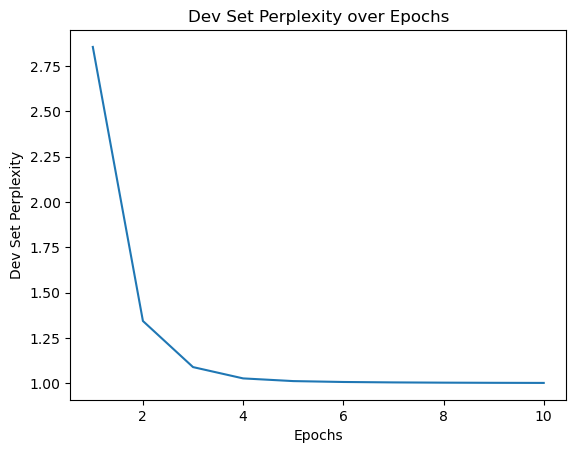

In [15]:
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# RNN Language Model
class RNNLanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(RNNLanguageModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.rnn(x)
        output = self.fc(output)
        return output

# Hyperparameters
BATCH_SIZE = 32  # Reduced batch size
EMBEDDING_DIM = 100  # Reduced size
HIDDEN_DIM = 128    # Reduced size
LR = 0.001
EPOCHS = 10  # Reduced number of epochs
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Create DataLoader
train_dataset = TensorDataset(train_data_padded)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dev_dataset = TensorDataset(dev_data_padded)
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)

# Initialize model, loss, and optimizer
vocab_size = len(vocab)
model = RNNLanguageModel(vocab_size, EMBEDDING_DIM, HIDDEN_DIM).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=token2index['<PAD>'])
optimizer = optim.Adam(model.parameters(), lr=LR)

# Initialize list to store dev perplexities
dev_perplexities = []

# Training Loop
for epoch in range(EPOCHS):
    model.train()
    
    for batch_data in train_loader:
        batch_data = batch_data[0].to(device)  # DataLoader returns a tuple
        
        # Forward pass and loss computation
        logits = model(batch_data)
        loss = criterion(logits.view(-1, vocab_size), batch_data.view(-1))
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate on dev set
    model.eval()
    dev_loss_list = []
    with torch.no_grad():
        for dev_batch in dev_loader:
            dev_batch = dev_batch[0].to(device)
            dev_logits = model(dev_batch)
            dev_loss = criterion(dev_logits.view(-1, vocab_size), dev_batch.view(-1))
            dev_loss_list.append(dev_loss.item())
        
        avg_dev_loss = sum(dev_loss_list) / len(dev_loss_list)
        dev_perplexity = torch.exp(torch.tensor(avg_dev_loss)).item()
        dev_perplexities.append(dev_perplexity)
    
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item()}, Avg Dev Loss: {avg_dev_loss}, Dev Perplexity: {dev_perplexity}")

# Plotting dev set perplexity over epochs
plt.plot(range(1, EPOCHS + 1), dev_perplexities)
plt.xlabel('Epochs')
plt.ylabel('Dev Set Perplexity')
plt.title('Dev Set Perplexity over Epochs')
plt.show()

4.2) Now measure the space saving amount of the trained model on the test text.
Also check that when you decompress the compressed test text, you get exactly the same string as the test text.

Note: You may need to strip off the new line character from the end of the test text when comparing it to the decompressed text.

4.3) Now you need to analyse the model's output.
Split the test text into sentences and compress each individual sentence.
Print out the top 5 most compressed sentences and the top 5 least compressed sentences according to the space saving metric together with the compressed sentences.

4.4) Is the reason for whether a sentence is compressible or not due to its similarity to the train set (a sentence that is similar to one in the train set would be easier to predict and thus more tokens will be compressed)?
Find out the answer to this by doing the following:

Extract all the trigrams from the train set (you can use `nltk.trigrams` to do this).
For each sentence in the test set, count how many of its trigrams are also found in the train set.
Turn this count into a domain similarity measure by dividing it by the number of trigrams in the test sentence.

Note: In order for this fraction to be meaningful from the language model's point of view, the edge token must be added to the front of the test sentences and out-of-vocabulary tokens must be replaced with the unknown token.

Create a list that maps each sentence's domain similarity to its space saving amount.
Plot a scatter plot showing how the domain similarity measure relates to the space saving amount of each test sentence.
If there is a correlation between these two measures, then the points in the scatter plot will form approximately into a straight line.

4.5) The scatter plot should not have created a straight line and should show a lot of bias towards very low space saving amounts, regardless of domain similarity.
Why is domain similarity not enough for explaining the compressability?

## 5) Conclusions (10%)

Write the following conclusions:

5.1) What is a simple change in the compression algorithm that can be made to increase compression?
Do not suggest any fundamental changes; the algorithm must still work by predicting missing tokens.

5.2) Write, in less than 300 words, your interpretation of the results and how you think the model could perform better.
You should talk about things like overfitting/underfitting and whether the model is learning anything deep about English sentences.